<a href="https://colab.research.google.com/github/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/7506_R_TP2_GRUPO09_ENTREGA_N3(redes).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuración inicial

In [1]:
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 8.3 MB/s 
     |████████████████████████████████| 1.6 MB 53.5 MB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras.models import Sequential
from keras.layers.core import Dense
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import Adam

np.random.seed(1)
tf.random.set_seed(1)

In [3]:
dataset_train_clasificacion = pd.read_csv("/content/drive/MyDrive/OrgaTP2/DatasetTrainClasificacion.csv")
dataset_test_clasificacion = pd.read_csv("/content/drive/MyDrive/OrgaTP2/DatasetTestClasificacion.csv")

dataset_train_regresion = pd.read_csv("/content/drive/MyDrive/OrgaTP2/DatasetTrainRegresion.csv")
dataset_test_regresion = pd.read_csv("/content/drive/MyDrive/OrgaTP2/DatasetTestRegresion.csv")

In [4]:
target_train_clasificacion_categorico = pd.read_csv("/content/drive/MyDrive/OrgaTP2/clasificacion_target_train.csv")
target_test_clasificacion_categorico = pd.read_csv("/content/drive/MyDrive/OrgaTP2/clasificacion_target_test.csv")

target_train_regresion = pd.read_csv("/content/drive/MyDrive/OrgaTP2/regresion_target_train.csv")
target_test_regresion = pd.read_csv("/content/drive/MyDrive/OrgaTP2/regresion_target_test.csv")

target_train_clasificacion_categorico.drop("Unnamed: 0", axis = 1, inplace=True)
target_test_clasificacion_categorico.drop("Unnamed: 0", axis = 1, inplace=True)

In [5]:
le = preprocessing.LabelEncoder()
target_train_clasificacion = le.fit_transform(target_train_clasificacion_categorico)

target_test_clasificacion = le.transform(target_test_clasificacion_categorico)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Redes neuronales

Escalamos los datos.

In [14]:
sscaler=StandardScaler()
sscaler.fit(dataset_train_clasificacion)

StandardScaler()

In [15]:
x_train_clasificacion = sscaler.transform(dataset_train_clasificacion)
x_test_clasificacion = sscaler.transform(dataset_test_clasificacion)

## Clasificación

In [16]:
outputs = {
    "bajo": 0,
    "medio": 1,
    "alto": 2,
}

Creamos el modelo secuencial de Keras.

In [17]:
def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Dense(
      hp.Int('units', min_value=32, max_value=512, step=32),
      activation=hp.Choice("activation", ["relu", "tanh"])))
  model.add(keras.layers.Dense(3, activation='relu'))
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
                optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=["accuracy"])
  return model

In [18]:
tuner = kt.RandomSearch(
    build_model,
    objective='loss',
    max_trials=2,
    project_name="TP2",
    overwrite=True)

In [19]:
tuner.search(x_train_clasificacion, target_train_clasificacion, epochs=5)
best_model = tuner.get_best_models()[0]

Trial 2 Complete [00h 00m 42s]
loss: 1.118725299835205

Best loss So Far: 1.0986274480819702
Total elapsed time: 00h 01m 24s


In [20]:
tuner.results_summary()

Results summary
Results in ./TP2
Showing 10 best trials
Trial summary
Hyperparameters:
units: 512
activation: relu
lr: 0.004612438463359445
Score: 1.0986274480819702
Trial summary
Hyperparameters:
units: 288
activation: tanh
lr: 0.009534114815412765
Score: 1.118725299835205


539/539 [==============================] - 1s 1ms/step


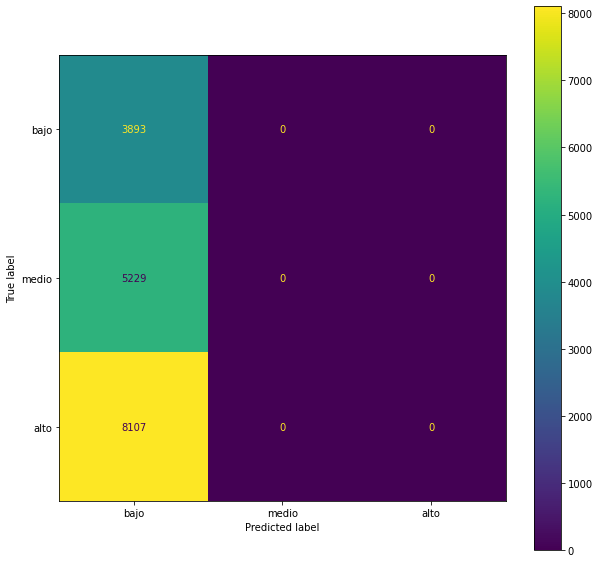

In [21]:
def clasificar_propiedad(entrada):
  prediccion = best_model.predict(entrada)
  arg_max = np.argmax(prediccion, axis=1)
  return arg_max

y_test = clasificar_propiedad(x_test_clasificacion)

# Plot confusion matrix
fig, ax = plt.subplots(1,1,figsize=(10,10))
dsp = ConfusionMatrixDisplay.from_predictions(target_test_clasificacion,y_test,display_labels=outputs.keys(),ax=ax)

## Regresión